# Impact on Housing and Community

This notebook shows an analysis of the impact of the war on Gaza for housing and communities. This is done using the following indicators as of February 2nd, 2024 

* Percentage of damaged residential buildings
* Percentage of people living in/near residential buidlings that were damaged
* Percentage of School Damaged
* Places of Public Amenities Damaged
* Percentage of Homes without (observed) Electricity
* Percentage Residential Solar Panels Damaged



In [1]:
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter
from palettable.cartocolors.qualitative import Prism_10, Vivid_10
from palettable.tableau import ColorBlind_10, TableauMedium_10

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

## Percentage of damaged residential buildings in Gaza as of Feb 2nd 2024

In [2]:
# read shapefiles
PSE = geopandas.read_file(
    "../../data/boundaries/pse_adm_pamop_20231019_shp/pse_admbnda_adm1_pamop_20231019.shp"
)
PSE = geopandas.read_file(
    "../../data/boundaries/pse_adm_pamop_20231019_shp/pse_admbnda_adm2_pamop_20231019.shp"
)
GAZA = PSE[PSE["ADM1_EN"] == "Gaza Strip"]

In [3]:
BUILDINGS_OSM = geopandas.read_file(
    "../../data/damage_assessment/delivery8_2Feb2024/vectors/2.5sigma/damaged_OSM_buildings_02Feb2024_2_5sigma.shp"
).to_crs("EPSG:4326")

BUILDINGS_OSM = geopandas.sjoin(BUILDINGS_OSM, GAZA)
BUILDINGS_OSM["type"] = BUILDINGS_OSM["type"].fillna("")

# BUILDINGS_MS = geopandas.read_file(
#     "../../data/damage_assessment/delivery8_2Feb2024/vectors/2.5sigma/damaged_Microsoft_buildings_02Feb2024_2_5sigma.shp"
# ).to_crs("EPSG:4326")

# BUILDINGS_MS = geopandas.sjoin(BUILDINGS_MS, GAZA)
# BUILDINGS_MS["type"] = BUILDINGS_OSM["type"].fillna("")

In [4]:
left = (
    BUILDINGS_OSM[BUILDINGS_OSM["_up7mean"] >= 0.2]
    .value_counts(["ADM2_EN", "type"])
    .to_frame("damaged")
)
right = BUILDINGS_OSM.value_counts(["ADM2_EN", "type"]).to_frame("total")

df = pd.merge(left, right, on=["ADM2_EN", "type"]).reset_index()
df["perc"] = 100 * df["damaged"] / df["total"]

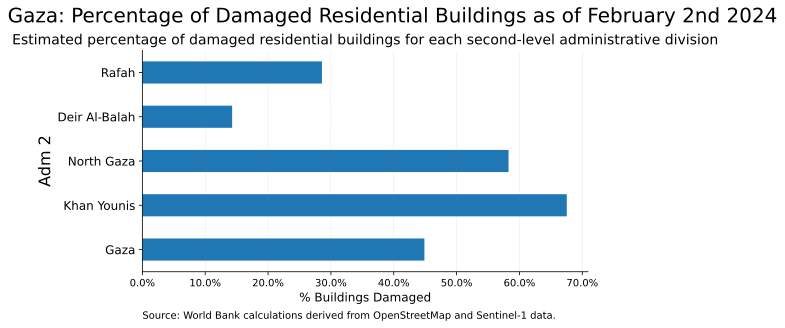

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.suptitle("Gaza: Percentage of Damaged Residential Buildings as of February 2nd 2024", y=1.03, fontsize=20, x=0.56)

df.pivot_table("perc", "ADM2_EN", "type")[
    ["residential"]
].plot(ax=ax, kind="barh", legend = False)

# Add labels and customization
ax.set_xlabel("% Buildings Damaged", fontsize=12)

ax.set_ylabel("Adm 2", fontsize=16)
ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{}%".format(y)))

ax.grid(axis="x", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
#ax.legend()

ax.set_title(
    "Estimated percentage of damaged residential buildings for each second-level administrative division",
    fontsize=14,
)
ax.text(
    0,
    -0.2,
    "Source: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
);

### Observations 

* Nearly 70% of the residential buildings in Khan Younis are damaged. The attacks on October 7th first started in the Norther parts of Gaza closer to Gaza city. of the residential buidlings in ADM2 regions of Gaza, Deir Al-Balah has the highest reported on OpenStreetMaps with 439 buildings. Khan Younis, as a reported number of buildings of 242. This could potentially also be because of the announcement of evacuation zones in Khan Younis by [Israel Defense Forces](https://www.reuters.com/graphics/ISRAEL-PALESTINIANS/MAPS/movajdladpa/)
* North Gaza has the second highest % of damaged buildings. The attacks started in that region on October 7th (source)

## Percentage of people who potentially impacted from the damage to residential buildings

In [6]:
from shapely.geometry import Point

def convert_to_gdf(df, X=None, Y=None):
    if 'latitude' in df.columns:
        geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
        gdf = geopandas.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
    else:
        geometry = [Point(xy) for xy in zip(df[Y], df[X])]
        gdf = geopandas.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

    return gdf

In [7]:
POPULATION = pd.read_csv('../../data/population/pse_pd_2020_1km_UNadj_ASCII_XYZ/pse_pd_2020_1km_UNadj_ASCII_XYZ.csv')
POPULATION = convert_to_gdf(POPULATION, 'Y', 'X')

POPULATION = POPULATION.sjoin(GAZA)
POPULATION = POPULATION[POPULATION['ADM1_EN']=='Gaza Strip']

In [8]:
import math
from shapely.geometry import Point, box

# Function to create a 1 km^2 box around a point
def create_square_km_box(point):
    lat, lon = point.y, point.x
    km_in_deg_lat = 1 / 111.32  # 1 km in degrees latitude
    km_in_deg_lon = 1 / (111.32 * math.cos(math.radians(lat)))  # 1 km in degrees longitude at this latitude
    
    # Define the bottom left and top right coordinates of the box
    bottom_left = (lon - km_in_deg_lon / 2, lat - km_in_deg_lat / 2)
    top_right = (lon + km_in_deg_lon / 2, lat + km_in_deg_lat / 2)
    
    # Create and return the box
    return box(*bottom_left, *top_right)


POPULATION['geometry'] = POPULATION['geometry'].apply(create_square_km_box)

c:\Users\sahit\anaconda3\envs\conflict-analyses\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [127]:
#POPULATION.drop(columns = 'index_right', inplace=True)
#BUILDINGS_OSM.drop(columns = 'index_right', inplace=True)
df = POPULATION[['X', 'Y', 'Z', 'geometry', 'ADM2_EN', 'ADM2_PCODE', 'ADM1_EN',
       'ADM1_PCODE', 'ADM0_EN', 'ADM0_PCODE']].sjoin(BUILDINGS_OSM[BUILDINGS_OSM['type']=='residential'][['osm_id', 'code', 'fclass', 'name', 'type', '_max', 'area','_landusefc', '_up7mean', 'geometry']])

In [128]:
left = POPULATION[['X', 'Y', 'Z', 'ADM2_EN', 'ADM1_EN', 'ADM0_EN']]

right = df[df['type']=='residential'][['X', 'Y', 'Z', '_up7mean']].groupby(['X', 'Y', 'Z']).mean().reset_index()

df = left.merge(right, on = ['X', 'Y', 'Z'])

In [129]:
def damage_ranges(mean):
    if mean<=0.2:
        return 'No damage'
    elif mean>0.2 and mean<=0.4:
        return 'Low damage'
    elif mean>0.4 and mean <=0.6:
        return 'Moderate damage'
    elif mean>0.7:
        return 'High damage'

In [131]:
df['damage_categories'] = df['_up7mean'].apply(lambda x: damage_ranges(x))

In [132]:
df = df.groupby(['ADM0_EN','ADM1_EN','ADM2_EN', 'damage_categories'])[['Z']].sum().reset_index()

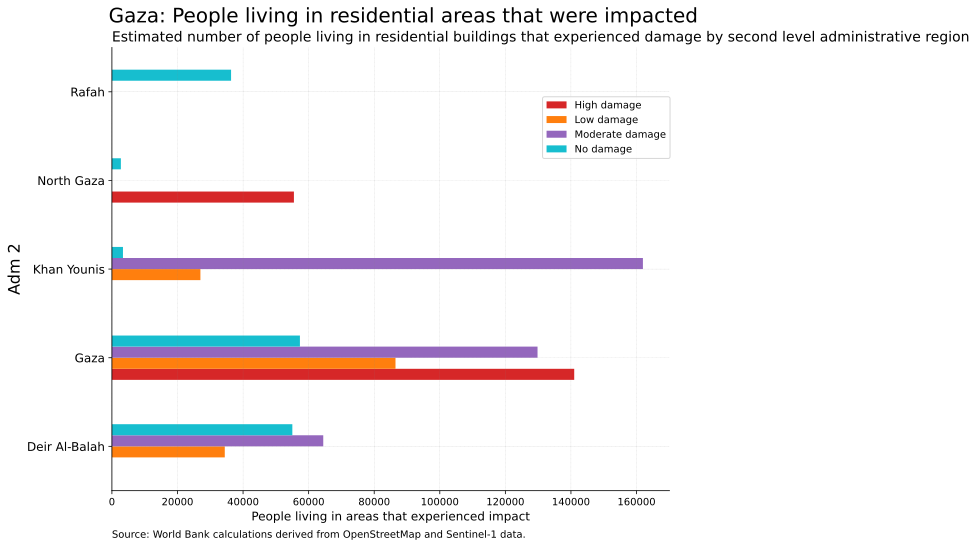

In [151]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.suptitle("Gaza: People living in residential areas that were impacted", y=0.95, fontsize=20, x=0.53)

df[['ADM2_EN', 'damage_categories', 'Z']].pivot_table( 'Z', 'ADM2_EN','damage_categories').plot(
    ax=ax, kind="barh", color=['#D62728', '#FF7F0E', '#9467BD', '#17BECF']
)

# Add labels and customization
ax.set_xlabel("People living in areas that experienced impact", fontsize=12)
#ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{}%".format(y)))
ax.set_ylabel("Adm 2", fontsize=16)
ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.grid(which="both", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
ax.legend(bbox_to_anchor=(1.01, 0.9))

ax.set_title(
    "Estimated number of people living in residential buildings that experienced damage by second level administrative region",
    fontsize=14,loc='left'
)
ax.text(
    0,
    -0.1,
    "Source: World Bank calculations derived from OpenStreetMap and Sentinel-1 data. Low damage represents a score of average damage in the 1km*1km grid to be less than 0.2.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
);

### Observations 

* Both North Gaza (523k) and Gaza (869k) have higher population than Khan Younis (476k). This is a potential reason for why the damage is higher in Khan Younis but the people impacted are greater in the other two administrative regions.

## Percentage of schools and places of worship damaged

In [29]:
POI = geopandas.read_file(
    "../../data/damage_assessment/delivery8_2Feb2024/vectors/2.5sigma/damaged_pois_1_02Feb2024_2_5sigma.shp"
).to_crs("EPSG:4326")

POI = geopandas.sjoin(POI, GAZA)
POI["fclass"] = POI["fclass"].fillna("")

In [30]:
def get_poi_classification(fclass):
    if fclass in [
        "school",
        "kindergarten",
        "university",
        "college",
    ]:
        return "Education"
    if fclass in [
        "tower",
        "wastewater_plant",
        "water_tower",
        "telephone",
        "water_well",
        "drinking_water",
        "recycling",
    ]:
        return "Infrastructure"
    if fclass in [
        "pharmacy",
        "dentist",
        "doctors",
        "hospital",
        "clinic",
        "nursing_home",
    ]:
        return "Health"
    if fclass in [
        "public_building",
        "police",
        "courthouse",
        "library",
        "monument",
        "post_office",
        "memorial",
        "community_centre",
        "town_hall",
        "museum",
        "arts_centre",
        "sports_centre",
        "tourist_info",
        "fire_station",
    ]:
        return "Public Amenities"

    elif fclass in [
        "clothes",
        "supermarket",
        "restaurant",
        "laundry",
        "cafe",
        "computer_shop",
        "convenience",
        "furniture_shop",
        "shoe_shop",
        "bakery",
        "hotel",
        "hairdresser",
        "fast_food",
        "bank",
        "viewpoint",
        "artwork",
        "picnic_site",
        "chalet",
        "caravan_site",
        "greengrocer",
        "beauty_shop",
        "car_dealership",
        "attraction",
        "pub",
        "waste_basket",
        "nightclub",
        "playground",
        "department_store",
        "outdoor_shop",
        "atm",
        "butcher",
        "car_rental",
        "doityourself",
        "guesthouse",
        "beverages",
        "theatre",
        "newsagent",
        "cinema",
        "mobile_phone_shop",
        "car_wash",
        "bookshop",
        "hostel",
        "sports_shop",
        "castle",
        "pitch",
        "car_sharing",
        "vending_machine",
        "food_court",
        "gift_shop",
        "camp_site",
        "veterinary",
        "post_box",
        "florist",
        "jeweller",
        "chemist",
        "motel",
        "alpine_hut",
        "mall",
        "kiosk",
        "bicycle_shop",
        "bench",
        "optician",
        "travel_agent",
        "biergarten",
        "toy_shop",
        "bar",
        "fountain",
        "archaeological",
        "shelter",
        "park",
        "stationery",
        "market_place",
        "zoo",
    ]:
        return "Places of Economic Activity"

In [31]:
POI["type"] = POI["fclass"].apply(get_poi_classification)

In [33]:
left = POI[POI["_up7max"] >= 0.5].value_counts(["ADM2_EN", "type"]).to_frame("damaged")
right = POI.value_counts(["ADM2_EN", "type"]).to_frame("total")

df = pd.merge(left, right, on=["ADM2_EN", "type"]).reset_index()
df["perc"] = 100 * df["damaged"] / df["total"]

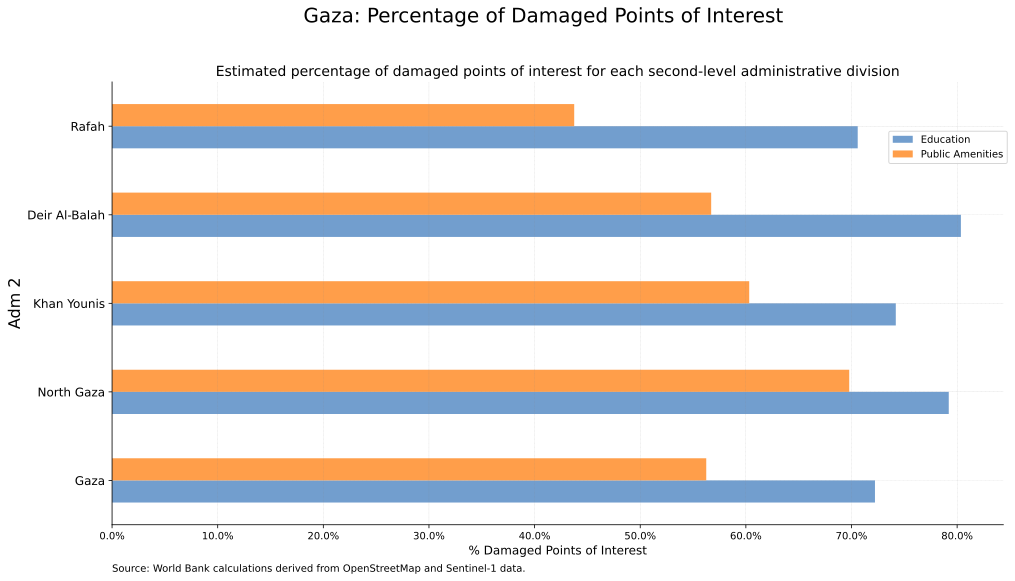

In [42]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.suptitle("Gaza: Percentage of Damaged Points of Interest", y=1.01, fontsize=20)

df.pivot_table("perc", "ADM2_EN", "type")[['Education', 'Public Amenities']].plot(
    ax=ax, kind="barh", color=TableauMedium_10.mpl_colors
)

# Add labels and customization
ax.set_xlabel("% Damaged Points of Interest", fontsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{}%".format(y)))
ax.set_ylabel("Adm 2", fontsize=16)
ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.grid(which="both", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
ax.legend(bbox_to_anchor=(1.01, 0.9))

ax.set_title(
    "Estimated percentage of damaged points of interest for each second-level administrative division",
    fontsize=14,
)
ax.text(
    0,
    -0.1,
    "Source: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
);